In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage
import pandas as pd
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

Populating the interactive namespace from numpy and matplotlib


In [2]:
def datos(direccion):
    with open(direccion, encoding="latin-1") as vboxdata:
        section = []
        time = []
        lat = []
        longi = []
        vel = []
        height = []
        vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat.append(float(linesplit[2]))
                longi.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))

    time = np.asarray(time)
    lat = np.asarray(lat)
    longi = np.asarray(longi)
    vel = np.asarray(vel)
    height = np.asarray(height)
    time_base = time[0]
    time = time - time_base
    lat = lat/60.0
    longi = -longi/60.0
    datos={'time':time,'lat':lat,'longi':longi,'vel':vel,'height':height}
    resul= pd.DataFrame(data=datos,columns=['time','lat','longi','vel','height'])
    return (resul)


In [3]:
def aVueltafil(datos,i,f,sig):
    y=datos['lat'][i:f]
    x=datos['longi'][i:f]
    vel=datos['vel'][i:f]
    tiempo=datos['time'][i:f]
    tiem=np.array(tiempo)
    ddt=tiem[1]-tiem[0]
    acel=ndimage.gaussian_filter1d(vel*(5/18), sigma=sig, order=1, mode='wrap') / ddt
    #acel=numpy.gradient(vel*(5/18))
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fig,axs=subplots(1,1)
    norm = plt.Normalize(vel.min(), vel.max())
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(vel)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line)
    axs.autoscale()
    title("Recorrido")
    plt.show()
    
    figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plot(tiempo-tiempo[i],vel)
    title("Velocidad contra tiempo")
    xlabel("Tiempo")
    ylabel ("Velocidad")
    plt.subplot(1,2,2)
    plot(tiempo-tiempo[i],acel)
    title("Aceleración contra tiempo")
    xlabel("tiempo")
    ylabel ("Aceleracion")
    
    Vmax=vel.max()
    Tvuelta=datos['time'][f]-datos['time'][i]
    
    print('El tiempo de vuelta fue: ',Tvuelta,'s')
    print('La velocidad maxima fue: ',Vmax,'km/h')

In [4]:
def aVuelta(datos):
    figure()
    plot(datos.index.values,datos['time'])
    title("Tiempo")
    xlabel("i")
    ylabel ("Tiempo")
    figure()
    plot(datos['lat'],datos['longi'])
    title("Recorrido")
    xlabel("Lat")
    ylabel ("Longi")
    figure()
    plot(datos['time'],datos['vel'])
    title("Velocidad contra tiempo")
    xlabel("tiempo")
    ylabel ("Velocidad")

In [5]:
datosElec=datos('DataElec/VBS__047.VBO')
datosCom=datos('DataCom/VBOX0019.VBO')

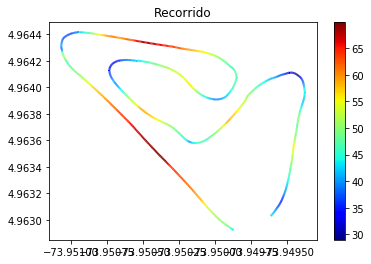

El tiempo de vuelta fue:  57.25 s
La velocidad maxima fue:  69.87 km/h


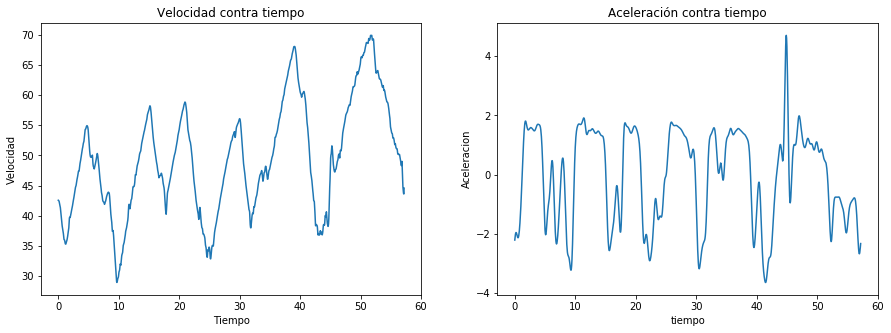

In [6]:
aVueltafil(datosElec,355,1500,5)

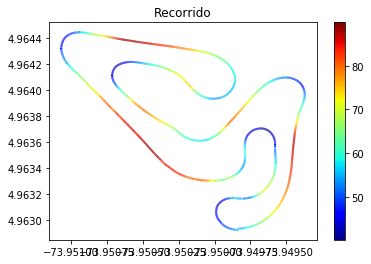

El tiempo de vuelta fue:  55.85 s
La velocidad maxima fue:  89.951 km/h


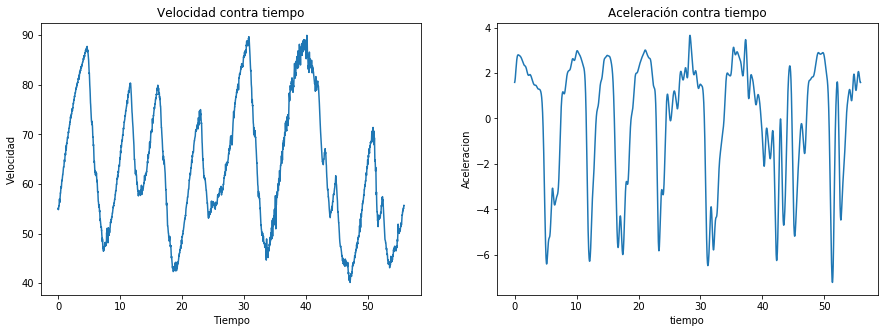

In [7]:
aVueltafil(datosCom,15690,21275,20)

Para la aceleración se tiene:

$(M+M_r)a_x = \frac{T_e N_c \eta_t}{r} - R_x - D_A$ [Ecuación 1]  

Dónde:

$M=$ masa del Kart

$M_r=$ masa equivalente de los elementos rotativos

$a_x=$ aceleracion

$T_e=$ torque del motor

$N_c=$ relación de transmisión

$ \eta_t=$ eficiencia de la transmisión

$r=$ radio efectivo de la llanta

$R_x=f_rW $ es la fuerza de resistencia a la rodadura  

$D_A = \frac{1}{2}\rho A_f C_d v_x^2 $ es la fuerza de arrastre aerodinámico 


In [8]:
def frodadura_const(vx,wx):# w= peso del kart, vx=velocidad del kart
    fr=0.01*(1+(vx/100.0))
    return wx*fr # (N)

In [9]:
def farrastre(vx,rhox,afx,cdx): 
    return (1.0/2.0)*rhox*afx*cdx*(vx)**2 

In [10]:
def Masaequi(Iwx,Idx,Iex,Ncx,rx):
    Me=((Iwx+Idx)+(Iex*(Ncx**2)))/(rx**2)
    return (Me)

In [11]:
def omega(vx,rx,Ncx):
    om=(vx/rx)*Ncx
    return (om)

In [12]:
def rendMotor(datos,i,f,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix,sig):
    vel=(datos['vel'][i:f])
    velms=(datos['vel'][i:f])*(5/18)
    tiempo=np.array((datos['time'][i:f])-(datos['time'][i]))
    ddt=tiempo[1]-tiempo[0]
    acel=ndimage.gaussian_filter1d(velms, sigma=sig, order=1, mode='wrap') / ddt
    #acel=numpy.gradient(velms)
    Rx=frodadura_const(vel,wx)
    Da=farrastre(velms,rhox,afx,cdx)
    Mr=Masaequi(Iwx,Idx,Iex,Ncx,rx)
    M=wx/9.81
    Te=(((M+Mr)*acel+Rx+Da)*rx)/(Ncx*efix)
    #Te[Te<0]=0
    velAngu=omega(velms,rx,Ncx)
    Pot=Te*velAngu
    
    
    figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plot(tiempo,Te)
    title("")
    xlabel("Tiempo")
    ylabel ("Torque Motor")
    plt.subplot(2,2,2)
    plot(tiempo,velAngu)
    title("")
    xlabel("tiempo")
    ylabel ("Vel Angular")
    plt.subplot(2,2,(3,4))
    plot(tiempo,Pot)
    title("")
    xlabel("tiempo")
    ylabel ("Potencia")

In [13]:
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
reje=0.02 # Radio eje de las llantas (m)
efi=0.95 # Eficiencia de transmisión
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
Ie=5.2E-3 # Inercia motor(kg m^2) 
mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
rin=0.0631 #radio interno del neumático (m)
rll=0.139 # Radio geométrico de las llantas en traseras (m)
r=0.98*rll # Radio efectivo llantas traseras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
Iw=2*illd+2*illt
meje=3.832 # Masa del eje (kg)
Id=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

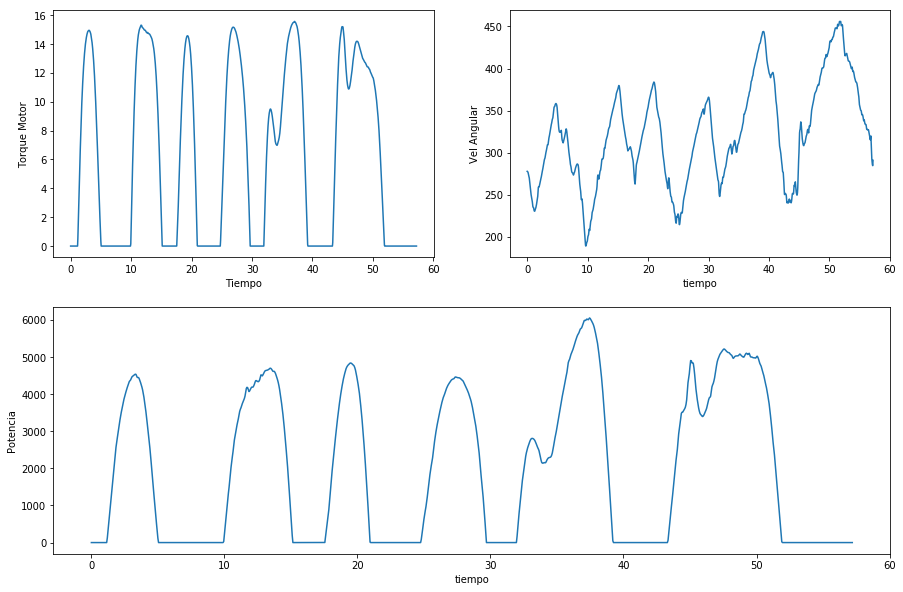

In [21]:
dp=20.0 # Dientes del piñon
dpl=64.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión
rendMotor(datosElec,355,1500,rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi,15)

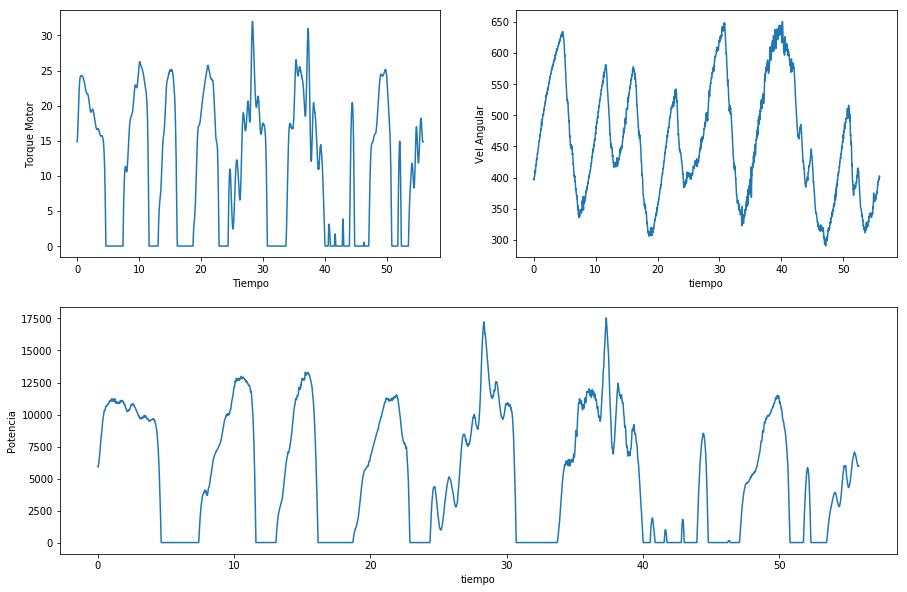

In [22]:
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión
rendMotor(datosCom,15690,21275,rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi,20)